### Potential Energy Methodology 
A couple different ways of estimating potential energy seem to come up in the literature so this notebook is dedicated to testing and comparing a couple of the methods. The chosen method will be loaded into the final work.

In [7]:
# Load Data and relevant modules - this is common to both wayss
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import cmocean
from Ipython.display import Image
# Probably Shouldn't do this but they annoy me
warnings.simplefilter("ignore")

pd.options.display.max_rows = 3000

pd.options.display.max_columns = 22


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max = 1000
wl_min = 500
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 2048
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
rho = gsw.density.rho(S, T, p_ctd)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth

strain = strain[idx_ctd, :]

S = S[idx_ctd,:]
T = T[idx_ctd,:]
rho = rho[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]


# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids (For plots)
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

**WARNING : The adiabatic leveling is a super slow function so try to avoid running a bunch of times for no reason**

In [10]:
# Calculate potential energy density spectrum using adiabatic leveling
# --- This is the part that needs tweaking I think

# Adiabatic leveling following Bray and Fofonoff 1981 -
# the actual code is a python version of Alex Forryan's Matlab code

# Order = order of polynomial fit to use
order = 1

# Pressure window - See Bray and Fofonoff 1981 for details
pressure_range = 400 

# axis = the depth increases on
axis = 0

# Use Adiabtic Leveling from Oceans Library
N2_ref, N2, strain, p_mid, rho_bar = oc.adiabatic_level(S,
                                                        T,
                                                        p_ctd,
                                                        lat,
                                                        pressure_range=pressure_range,
                                                        order=order,
                                                        axis=axis,
                                                        )


####  Isopyncal displacements from density surfaces

**V1 - Waterman et al. 2013-using density surfaces**
This uses the equation:

$$ \eta = \frac{\rho - \rho_{ref}}{\frac{d\rho_{ref}}{dz}} $$

where rho reference is neutral density. I am going to try it with neutral density and with the adiabatically leveled density surfaces and see how different it is and why. $\frac{d\rho}{dz}$ is computed by differencing the reference density surfaces over a 400 meter vertical window. According to *Waterman et al. 2013* this window should not make a big difference. for the reference density the mean of all the adiabatically leveled profiles is taken as the stratification varies signficantly across the profile.


In [12]:
rho_ref = np.nanmean(rho_bar, axis=1)

# Stick a nan to the top to make it the same size as the rho array
rho_ref = np.hstack((0, rho_ref))

# set differnece window to 400 meters
win = 400


# since all the data is on a normalized pressure grid use a single vertical vector to make it easier to handle
z = -1*gsw.z_from_p(p_ctd[:,0], lat[:,0])
dz = np.nanmean(np.diff(z))
step = int(np.floor(.5*win/dz))
eta = np.full_like(rho, np.nan)
for i in range(rho.shape[0]):
    
    # If in the TOP half of the profile the window needs to be adjusted
    if i - step < 0:
        lower = 0
        upper = int(2*step)
        
    # If in the BOTTOM half of the profile the window needs to be adjusted
    elif i + step > (rho.shape[0] - 1):
        lower = int(rho.shape[0] - 2*step)
        upper = -1 
        
    else:
        upper = i + step
        lower = i - step
    drefdz = (rho_ref[upper] - rho_ref[lower])/win
    
    eta[i,:] = (rho[i,:] -  rho_ref[i])/drefdz
        

### Get Spectrum to see how it worked
The kinetic energy calculations seem straight forward so they are just loaded in using the internal waves KE calculation function rather than show the whole code. Using these the wave components are calculated to see effects of different ways of potential energy calculations. **See main lee_wave.ipynb notebook for full details**

In [102]:
# Calculate KE spectrums (m2/s2)
z_ladcp = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime, ke_peaks = iwc.KE_UV(U, V, z_ladcp, ladcp_bins,
                                                    wl_min, wl_max, lc=wl_min-50,
                                                    nfft=1024, detrend='constant')
# Calculate PE spectrum using eta from above (m2/s2)
z_ctd = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean, pe_peaks = iwc.PE(N2, z, eta,
                                                wl_min, wl_max,
                                                ctd_bins, nfft=1024,
                                                detrend=False)




(0.0005, 0.01)

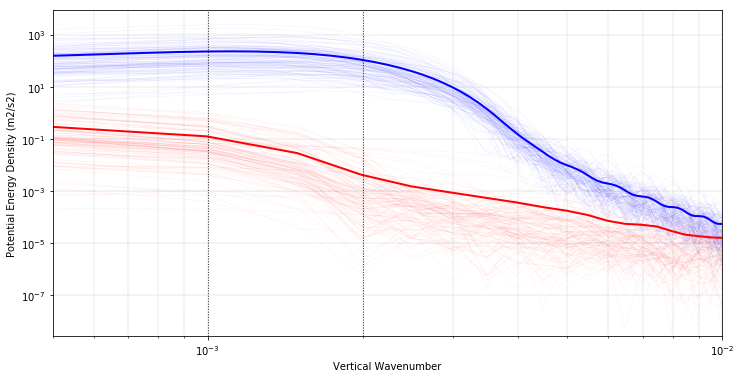

In [103]:
# Plot spectra to see what happened
m_plot = np.array([(1)/wl_max,
                       (1)/wl_max, (1)/wl_min,
                       (1)/wl_min])
plt.figure(figsize=[12,6])

plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', alpha=.05)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=2, c='b')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density')
plt.xlabel('Vertical Wavenumber')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', alpha=.05)
plt.loglog(PE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=2, c='r')
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
# plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel('Potential Energy Density (m2/s2)')
plt.xlabel('Vertical Wavenumber')
# plt.xlim(.0005, .01)

#### Get Wave Components (Frequency, horizontal wavenumber)

In [19]:
Etotal = 1027*(KE + PE) # Multiply by density to get Joules
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation - where did this come from?
omega = f*np.sqrt(((KE+PE)/(KE-PE))) # Waterman et al. 2012 (Ithink)

m = (2*np.pi)/800

kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean))) # Waterman et al. 2012
kh2 = (m/np.sqrt(N2mean))*(np.sqrt(omega**2 - f**2)) # Where (meyer i think?)

lambdaH = 1e-3*(2*np.pi)/kh
lambdaH2 = 1e-3*(2*np.pi)/kh2

# version 2 omega calculation
Rw = KE/PE # Unsure what to do with this just yet. 


In [38]:
table = oc.display(lambdaH, index=depths.flatten())
table.style.set_caption('Horizontal Wavelength V1')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,6.51171,23.2788,56.3436,37.644,16.3271,28.6432,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,10.4346,21.5714,38.1859,43.8668,100.999,180.27,147.985,138.646,22.7221,90.1412,41.1383,20.989,50.9278,34.9569,17.9345,45.3714,26.8534,22.2914,26.0903,20.3548
1536.0,17.7023,35.3966,61.5738,48.8316,138.059,171.504,407.863,144.375,84.0419,86.7923,73.6029,69.757,52.6607,96.1453,86.3935,63.9981,52.9255,24.3289,37.1987,60.9595,66.3383
2048.0,128.531,160.306,90.2609,105.492,191.409,414.669,1125.19,177.617,45.5439,134.78,102.111,80.2513,68.2692,75.5266,99.5855,75.1146,50.5563,65.0329,82.0839,79.8408,36.0599
2560.0,238.284,136.595,133.485,49.2177,84.0006,56.1808,259.842,66.1785,54.2265,70.5912,56.6095,57.4794,89.8382,122.807,88.8052,68.6064,30.1684,48.9486,72.8788,82.7194,243.463
3072.0,154.504,165.286,53.541,76.1341,26.8744,54.8892,204.796,148.222,56.9796,38.0445,51.5438,14.6811,71.8785,110.589,11.1029,17.9611,22.7672,23.6786,9.34735,21.698,90.3736


In [32]:
table = oc.display(lambdaH2, index=depths.flatten())
table.style.set_caption('Horizontal Wavelength V2')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,nan,nan,nan,nan,nan,6.56619,23.3121,56.3968,37.6842,16.3605,28.6785,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,10.4863,21.6298,38.2714,43.9628,101.206,180.636,148.286,138.928,22.7822,90.3269,41.2292,21.0467,51.037,35.0367,17.9886,45.4702,26.9196,22.3508,26.1554,20.4117
2,17.7819,35.5285,61.7926,49.0076,138.54,172.101,409.279,144.878,84.3374,87.0972,73.8627,70.0036,52.8495,96.4822,86.697,64.2252,53.1152,24.4265,37.3364,61.1763,66.5733
3,129.202,161.141,90.7339,106.044,192.406,416.826,1131.04,178.543,45.7878,135.483,102.645,80.6726,68.629,75.9236,100.107,75.5095,50.8255,65.376,82.5147,80.26,36.2564
4,239.859,137.499,134.369,49.5492,84.5591,56.5575,261.559,66.6204,54.5905,71.0619,56.989,57.8646,90.4351,123.62,89.3952,69.0642,30.3783,49.2784,73.3645,83.2695,245.072
5,155.93,166.812,54.0405,76.8401,27.1341,55.401,206.685,149.591,57.5105,38.4037,52.0252,14.8384,72.5456,111.611,11.2343,18.1446,22.9912,23.9105,9.468,21.9129,91.2102


In [39]:
table = oc.display(omega, index=depths.flatten())
table.style.set_caption('Intrinsic Frequency V2')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,-0.000366243,-0.000152369,-0.00012366,-0.000131591,-0.000181836,-0.00014133,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,nan,-0.000182722,-0.000135261,-0.000123044,-0.000121577,-0.000117773,-0.000117154,-0.000117291,-0.00011735,-0.00013356,-0.000118002,-0.000122208,-0.000136221,-0.00012038,-0.000124201,-0.000142699,-0.000121276,-0.000129044,-0.000134169,-0.00012973,-0.000137352
1536.0,-0.000132903,-0.000121086,-0.00011828,-0.000119104,-0.000117152,-0.000117053,-0.000116902,-0.000117128,-0.000117629,-0.000117582,-0.000117859,-0.00011797,-0.000118794,-0.00011745,-0.000117588,-0.000118176,-0.000118775,-0.000125622,-0.000120694,-0.000118309,-0.000118086
2048.0,-0.000117087,-0.000117009,-0.000117309,-0.000117192,-0.000116968,-0.000116891,-0.000116873,-0.000116983,-0.000118586,-0.000117067,-0.000117213,-0.000117425,-0.000117637,-0.000117497,-0.000117231,-0.000117504,-0.000118264,-0.000117715,-0.000117401,-0.000117431,-0.000119595
2560.0,-0.00011692,-0.000117021,-0.000117028,-0.000118029,-0.000117269,-0.00011776,-0.000116912,-0.000117512,-0.000117826,-0.000117435,-0.000117747,-0.000117721,-0.000117219,-0.000117057,-0.000117227,-0.000117468,-0.000119929,-0.000118042,-0.0001174,-0.000117282,-0.000116917
3072.0,-0.000116954,-0.000116944,-0.000117572,-0.000117218,-0.000119631,-0.000117538,-0.000116918,-0.000116962,-0.00011749,-0.000118256,-0.000117627,-0.000125865,-0.00011726,-0.000117035,-0.000132165,-0.000122958,-0.000120698,-0.000120414,-0.000137918,-0.000121077,-0.000117117


/bin/sh: -c: line 0: syntax error near unexpected token `velocity_anomalies.png'
/bin/sh: -c: line 0: `[title](velocity_anomalies.png)'


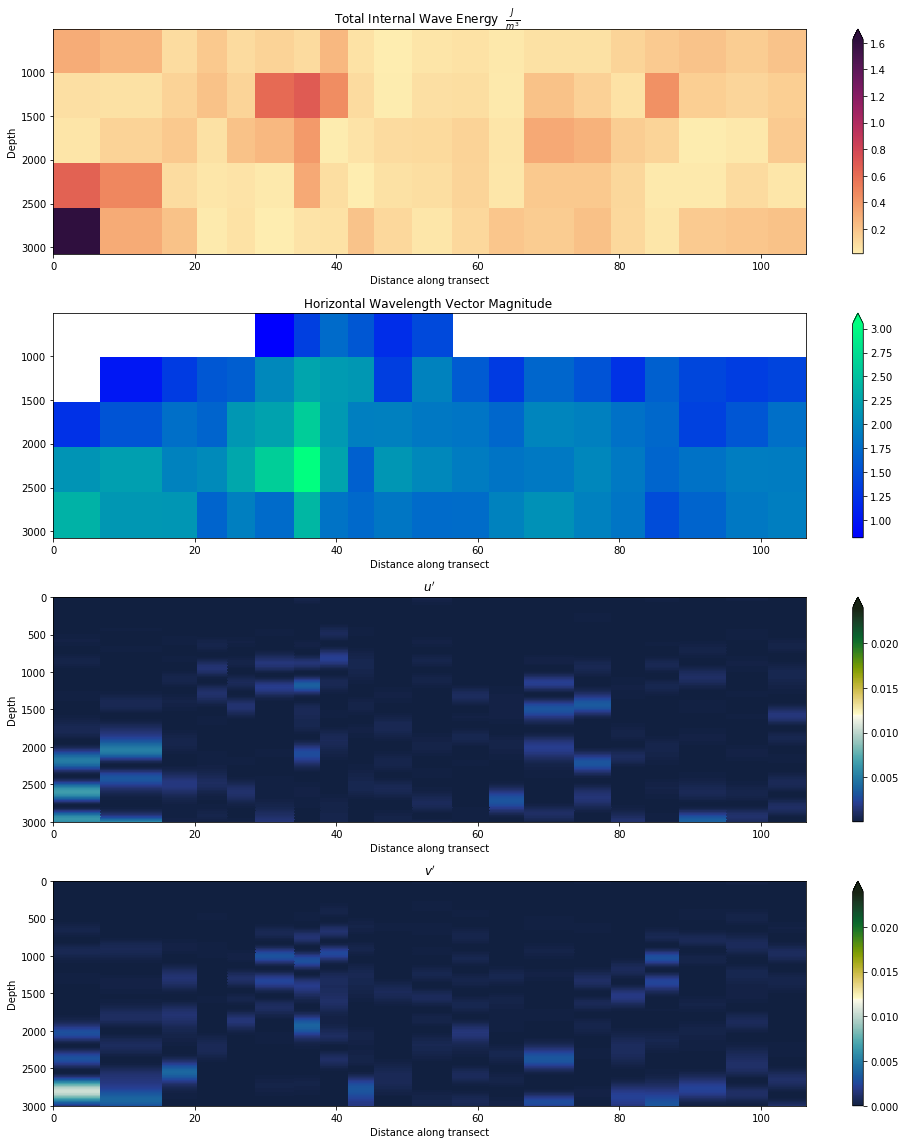

In [101]:
plt.figure(figsize=[14,16])
plt.subplot(411)
plt.pcolormesh(dist.flatten(), depths.flatten(), (Etotal), cmap=cmocean.cm.matter)
plt.colorbar(extend='max')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r'Total Internal Wave Energy  $\frac{J}{m^{3}}$  ')

plt.subplot(412)
plt.pcolormesh(dist.flatten(), depths.flatten(), np.log10(lambdaH), cmap='winter')
plt.colorbar(extend='max')
plt.gca().invert_yaxis()
plt.xlabel('Distance along transect')
plt.title('Horizontal Wavelength Vector Magnitude ')


plt.subplot(413)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), Uprime**2, cmap=cmocean.cm.delta)
plt.colorbar(extend='max')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$u'$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()

plt.subplot(414)
plt.pcolormesh(dist.flatten(), p_ladcp.flatten(), Vprime**2, cmap=cmocean.cm.delta)
plt.colorbar(extend='max')
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title(r"$v'$")
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.tight_layout()



![title](velocity_anomalies.png)